In [1]:
import spynnaker8 as p
import pyNN.spiNNaker as sim
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
%matplotlib inline

In [2]:
start_time = time.time()
simulation_time_step = 0.1
sim.setup(timestep = simulation_time_step)
TotalDuration = 1000.0
time_resol = 0.1
TimeInt = 1.0 / time_resol
TotalDataPoints = int(TotalDuration * TimeInt)
rate_Poisson_Inp_base = 25
bin_size = 1
per_bin_points = int(bin_size/simulation_time_step)
Total_bins = TotalDataPoints//per_bin_points

2021-06-11 22:11:53 INFO: Read cfg files: /home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg, /home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg, /home/spinnaker/.spynnaker.cfg
2021-06-11 22:11:53 INFO: Will search these locations for binaries: /home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/common_model_binaries : /home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/model_binaries
2021-06-11 22:11:53 WARNING: /home/spinnaker/work/reports has 44 old reports that have not been closed
2021-06-11 22:11:53 WARNING: A timestep was entered that has forced sPyNNaker to automatically slow the simulation down from real time by a factor of 10. To remove this automatic behaviour, please enter a timescaleFactor value in your .spynnaker.cfg
2021-06-11 22:11:53 INFO: Setting time scale factor to 10.
2021-06-11 22:11:53 INFO: Setting machine time step to 100 micro-seconds.


['/home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg', '/home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg', '/home/spinnaker/.spynnaker.cfg']


In [3]:
NumCells_exc = 80
NumCells_inh = 20
NumCells_extSource = 80

In [4]:
# Synaptic Conn params
conn_delay = 1.0
conn_weights = 5.0
conn_prob = 0.2

In [5]:
# excitatory cell params
exc_a_tonic = 0.02
exc_b_tonic = 0.2
exc_c_tonic = -65.0
exc_d_tonic = 6.0
exc_v_init_tonic = -65.0
exc_u_init_tonic = exc_b_tonic * exc_v_init_tonic

In [6]:
# inhibitory cell params
inh_a_tonic = 0.1
inh_b_tonic = 0.2
inh_c_tonic = -65.0
inh_d_tonic = 6.0
inh_v_init_tonic = -70.0
inh_u_init = inh_b_tonic * inh_v_init_tonic

In [7]:
# Time constants
tau_exc = 1.7

tau_inh = 2.5

In [8]:
# DC bias current
current_Pulse = 3.0
exc_cell_params = {
'a': exc_a_tonic, 'b': exc_b_tonic, 
'c': exc_c_tonic, 'd': exc_d_tonic,
#'v_init': exc_v_init_tonic, 'u_init': exc_u_init_tonic,
'tau_syn_E': tau_exc, 'tau_syn_I': tau_inh,
'i_offset': current_Pulse
               }

inh_cell_params = {
    'a' : inh_a_tonic, 'b': inh_b_tonic,
    
    'c': inh_c_tonic, 'd': inh_d_tonic,
    #'v_init' : inh_v_init_tonic,'u_init' : inh_u_init,
    'tau_syn_E' : tau_exc, 'tau_syn_I':tau_inh,
    'i_offset' : current_Pulse
               }

In [9]:
external_spike_source_pop = p.Population(NumCells_extSource,p.SpikeSourcePoisson,{'rate': rate_Poisson_Inp_base,'duration': 1000,'start': 100},label='spike_source_poisson')
exc_pop = p.Population(NumCells_exc, p.Izhikevich(**exc_cell_params), label='exc_pop')
inh_pop = p.Population(NumCells_inh, p.Izhikevich(**inh_cell_params), label='inh_pop')

In [10]:
#external to excitatory
Proj00 = p.Projection(external_spike_source_pop, exc_pop, p.FixedProbabilityConnector(p_connect=0.5),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#external to inhibitory
Proj01 = p.Projection(external_spike_source_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#excitatory to inhibitory
Proj02 = p.Projection(exc_pop, inh_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#inhibitory to excitatory
Proj03 = p.Projection(inh_pop, exc_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='inhibitory')

#inhibitory to inhibitory
Proj04 = p.Projection(inh_pop, inh_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='inhibitory')

#excitatory to excitatory

Proj05 = p.Projection(exc_pop, exc_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')



In [11]:
external_spike_source_pop.record("spikes") #need to store external spike source records and need to print them
exc_pop.record(("spikes", "v"))
inh_pop.record(("spikes", "v"))
p.run(TotalDuration)
external_spike_source = external_spike_source_pop.spinnaker_get_data("spikes")
exc_spikes = exc_pop.spinnaker_get_data("spikes")
inh_spikes = inh_pop.spinnaker_get_data("spikes")
exc_voltage = exc_pop.spinnaker_get_data("v")
inh_voltage = inh_pop.spinnaker_get_data("v")

2021-06-11 22:11:53 INFO: Starting execution process
2021-06-11 22:11:53 INFO: Simulating for 10000 0.1ms timesteps using a hardware timestep of 10us
2021-06-11 22:11:56 INFO: Time 0:00:03.087118 taken by SpallocMaxMachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2021-06-11 22:12:05 INFO: Time 0:00:08.643554 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2021-06-11 22:12:10 INFO: Time 0:00:04.769232 taken by PartitionAndPlacePartitioner
Created spalloc job 6011601
2021-06-11 22:12:10 INFO: Created spalloc job 6011601
Waiting for board power commands to complete.
2021-06-11 22:12:10 INFO: Waiting for board power commands to complete.
2021-06-11 22:12:15 INFO: Time 0:00:05.049249 taken by SpallocAllocator
2021-06-11 2

Getting profile data
|0%                          50%                         100%|
2021-06-11 22:13:09 INFO: Time 0:00:00.031963 taken by ProfileDataGatherer
2021-06-11 22:13:09 WARNING: spinnaker_get_data is non-standard PyNN and therefore may not be portable to other simulators. Nor do we guarantee that this function will exist in future releases.
Getting spikes for spike_source_poisson
|0%                          50%                         100%|
Getting spikes for exc_pop
|0%                          50%                         100%|
Getting spikes for inh_pop
|0%                          50%                         100%|
Getting v for exc_pop
|0%                          50%                         100%|
Getting v for inh_pop
|0%                          50%                         100%|


In [12]:
#print(exc_spikes) #print length of source spike data
print(len(exc_spikes))
#print(inh_spikes)
print(len(inh_spikes))
print(len(external_spike_source))
print(inh_spikes)

5730
2728
1756
[[  0.   17.9]
 [  0.   19.1]
 [  0.   20.1]
 ...
 [ 19.  969.1]
 [ 19.  977.7]
 [ 19.  990.2]]


In [13]:
spike_count_list = []
bin_list = []
for i in range(Total_bins + 1):
    spike_count_list.append(0)
for i in range(len(exc_spikes)):
    time_instance = int(exc_spikes[i][1]/bin_size)
    spike_count_list[time_instance] = spike_count_list[time_instance] + 1
for i in range(Total_bins + 1):
    bin_list.append(i)

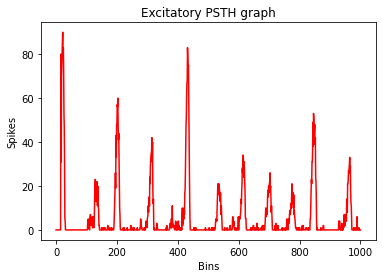

In [14]:
plt.figure(1)
plt.plot(bin_list,spike_count_list,color = 'red')
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Excitatory PSTH graph')
plt.show()

In [15]:
inh_spike_count_list = []
inh_bin_list = []
for i in range(Total_bins+1):
    inh_spike_count_list.append(0)
for i in range(len(inh_spikes)):
    inh_time_instance = int(inh_spikes[i][1] / bin_size)
    inh_spike_count_list[inh_time_instance] = inh_spike_count_list[inh_time_instance] + 1
for i in range(Total_bins+1):
    inh_bin_list.append(i)

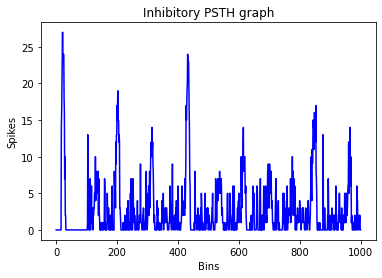

In [16]:
plt.figure(2)
plt.plot(inh_bin_list,inh_spike_count_list,color = 'blue')
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Inhibitory PSTH graph')
plt.show()

In [17]:
external_spike_count_list = []
external_bin_list = []
for i in range(Total_bins + 1):
    external_spike_count_list.append(0)
for i in range(len(external_spike_source)):
    external_time_instance = int(external_spike_source[i][1]/bin_size)
    external_spike_count_list[external_time_instance] = external_spike_count_list[external_time_instance] + 1
for i in range(Total_bins + 1):
    external_bin_list.append(i)

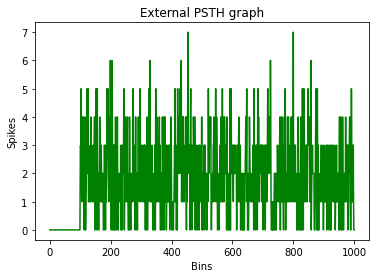

In [19]:
plt.figure(3)
plt.plot(external_bin_list,external_spike_count_list,color = 'green')
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('External PSTH graph')
plt.show()